In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import multirecording_spikeanalysis as spike

# Load the DataFrame using pandas
rce3_alone_clusters = pd.read_pickle("rce_pilot_3_alone_comp_cluster_ranges.pkl")

# Initialize the dictionary
timestamp_dicts = {}

# Loop through each row of the DataFrame to populate the dictionary
for index, row in rce3_alone_clusters.iterrows():
    # Define the key as a combination of session_dir and current_subject
    key = f"{row['session_dir']}"

    start_pos = key.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    key_without_suffix = key[:end_pos]
    
    # Initialize nested dictionary for this key if not already present
    if key not in timestamp_dicts:
        timestamp_dicts[key_without_suffix] = {}

    # Loop through the cluster_timestamps_ranges_dict to populate conditions
    for condition, ranges in row['cluster_timestamps_ranges_dict'].items():
        # Check if the condition key already exists, if not initialize a list
        if condition not in timestamp_dicts[key_without_suffix]:
            timestamp_dicts[key_without_suffix][str(condition)] = []

        # Extend the existing list with new ranges
        modified_ranges = [(start // 20, end // 20) for start, end in ranges]
        timestamp_dicts[key_without_suffix][str(condition)].extend(modified_ranges)

# Optionally, convert the lists to numpy arrays as in your previous code
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

rec1 = timestamp_dicts['20240320_171038_alone_comp_subj_4-2']

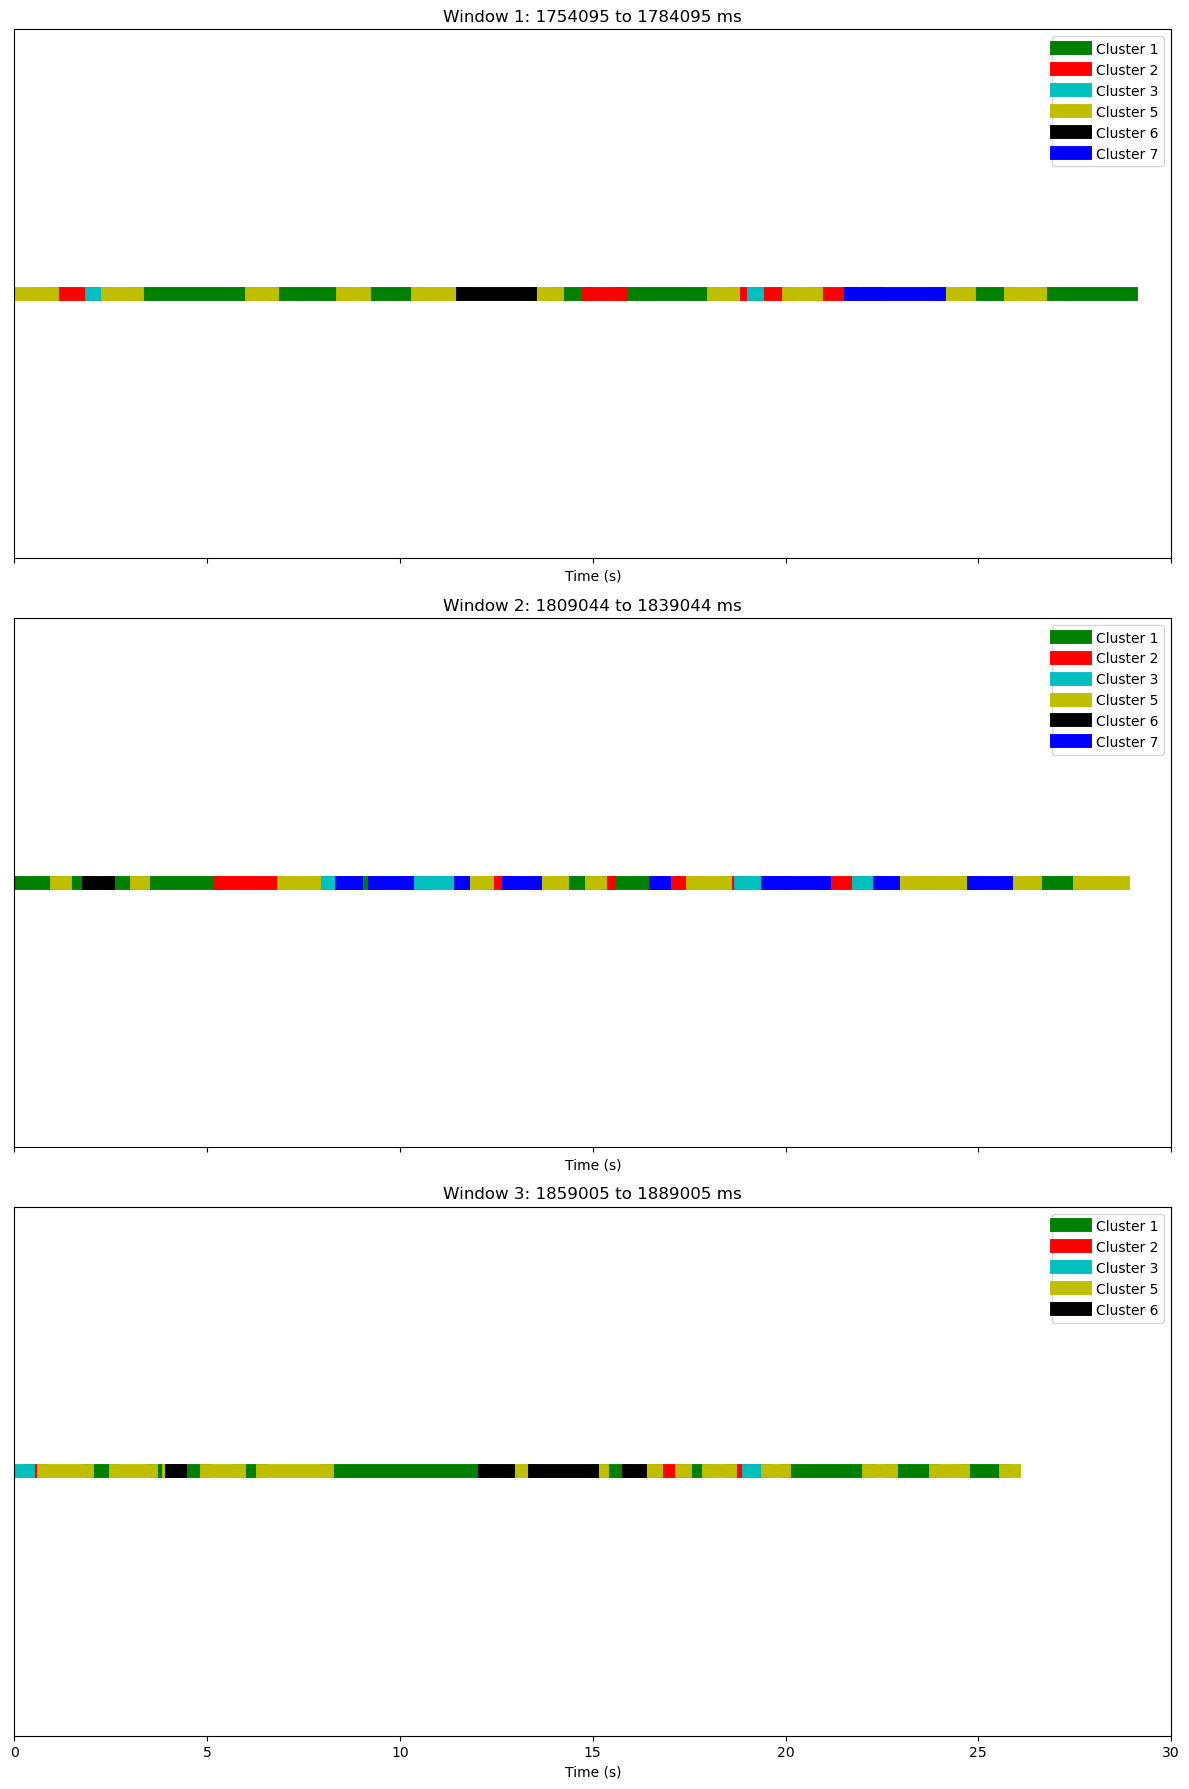

[(np.int64(1754095), np.int64(1784095)),
 (np.int64(1809044), np.int64(1839044)),
 (np.int64(1859005), np.int64(1889005))]

In [2]:
# Finding the lowest timestamp
min_timestamp = min(min(ranges[:, 0]) for ranges in rec1.values())

# Function to find the next starting point for the window
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the clusters
all_starts = np.concatenate([ranges[:, 0] for ranges in rec1.values()])

# Find the starting points for three dynamic windows
dynamic_windows = []
current_start = min_timestamp
for _ in range(3):
    next_start = find_next_start(current_start, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_start = next_start
r
# Prepare to replot with an updated legend order and handling cases where no data fits a window
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Colors for different cluster ids
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Dictionary to manage colors consistently across clusters
cluster_colors = {str(i): colors[i % len(colors)] for i in range(1, 8)}

# Conversion factor from milliseconds to seconds
ms_to_s = 1000

for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in sorted(rec1, key=int):  # Sort keys to ensure order in the legend
        ranges = rec1[key]
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / ms_to_s
                plot_end = (min(end, window_end) - window_start) / ms_to_s
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], 
                        linewidth=10, label=f"Cluster {key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

# Return the dynamic window definitions for verification
dynamic_windows

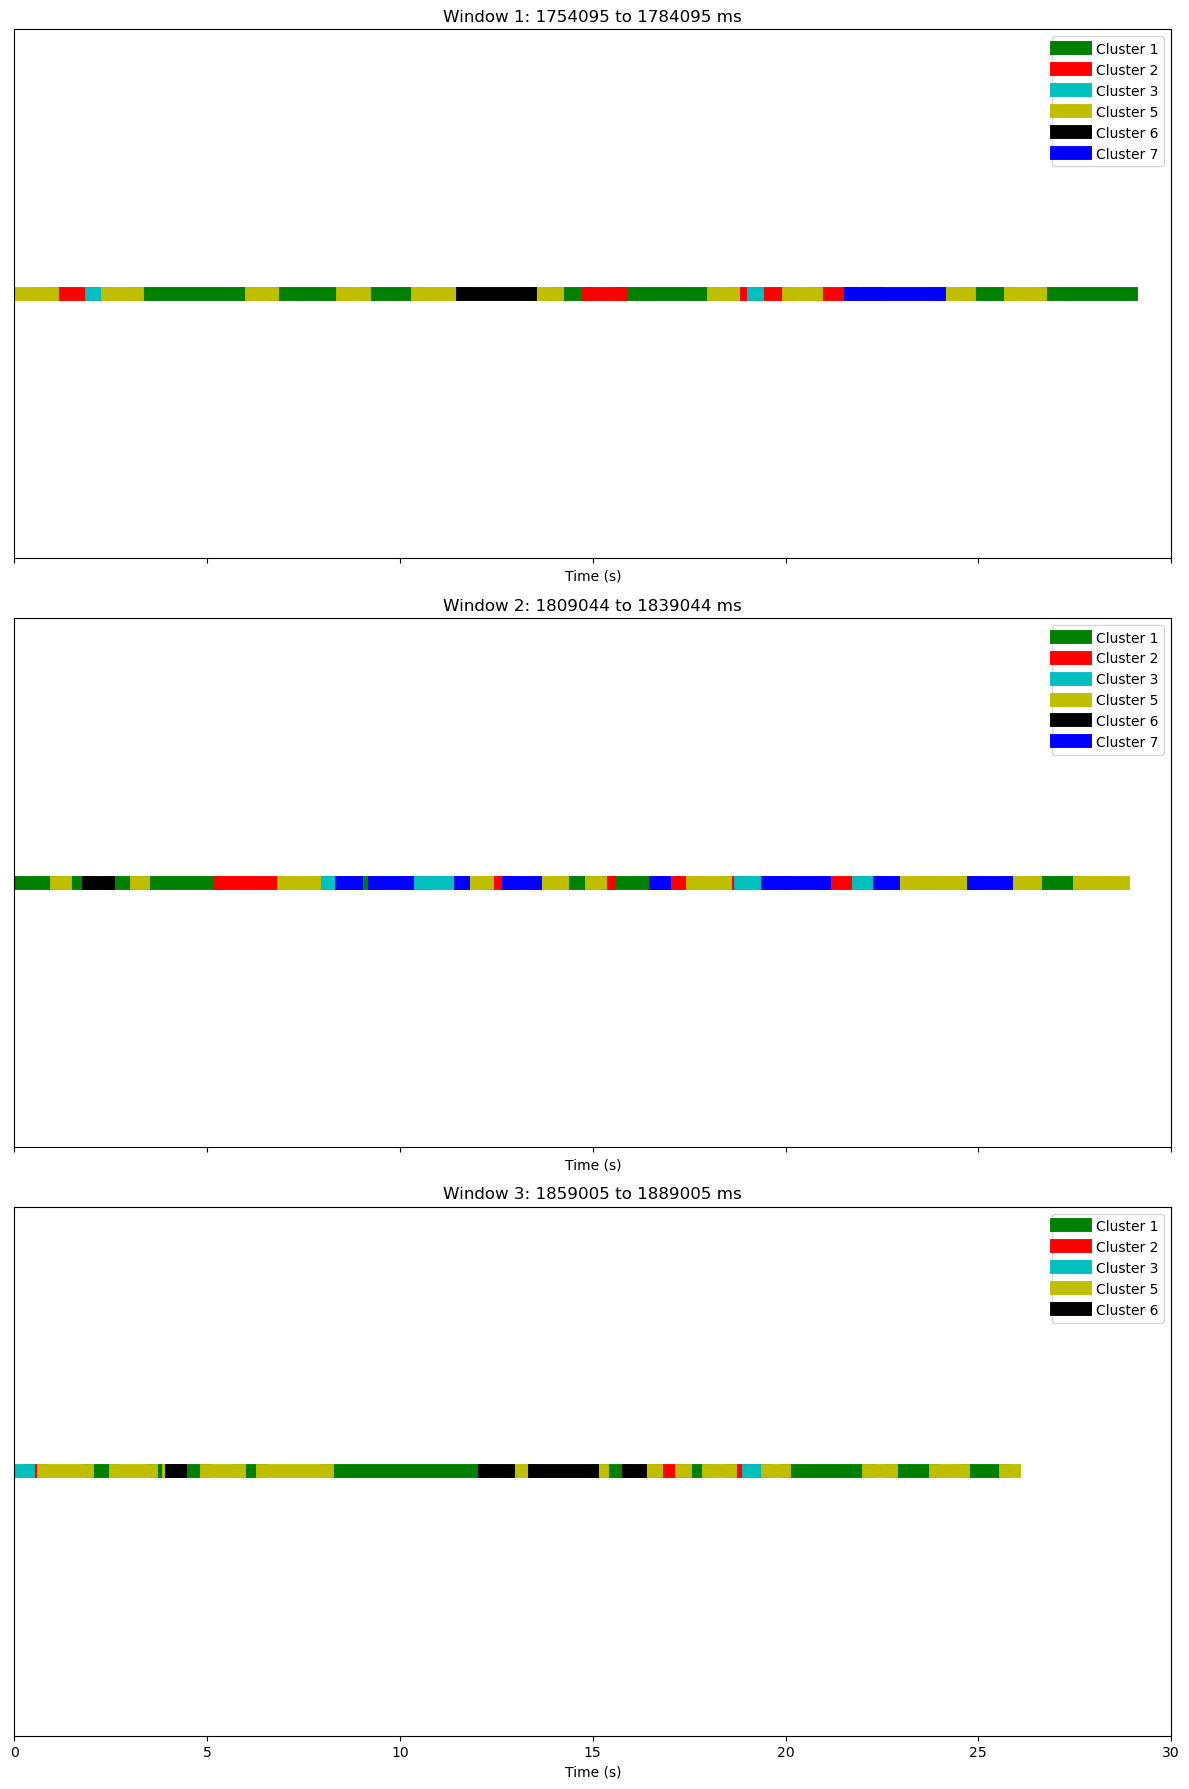

Window: 1754095 to 1784095
Window: 1809044 to 1839044
Window: 1859005 to 1889005


In [5]:
# Finding the lowest timestamp
min_timestamp = min(min(ranges[:, 0]) for ranges in rec1.values())

# Function to find the next starting point for the window
def find_next_start(current_start, all_timestamps, gap):
    # Find the first timestamp after the current start + gap
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the clusters
all_starts = np.concatenate([ranges[:, 0] for ranges in rec1.values()])

# Calculate dynamic windows starting from the minimum timestamp
dynamic_windows = []
current_start = min_timestamp
for _ in range(3):
    next_start = find_next_start(current_start, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_start = next_start

# Prepare to replot with an updated legend order and handling cases where no data fits a window
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Colors for different cluster ids
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Dictionary to manage colors consistently across clusters
cluster_colors = {str(i): colors[i % len(colors)] for i in range(1, 8)}

# Conversion factor from milliseconds to seconds
ms_to_s = 1000

for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False  # Flag to check if any data is plotted

    for key in sorted(rec1, key=int):  # Sort keys to ensure order in the legend
        ranges = rec1[key]
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / ms_to_s
                plot_end = (min(end, window_end) - window_start) / ms_to_s
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], 
                        linewidth=10, label=f"Cluster {key}")
                data_present = True

    # Setting x-axis in seconds and formatting
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)

    # Only show legend if data was present
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

# Print dynamic window definitions for verification
for window in dynamic_windows:
    print(f"Window: {window[0]} to {window[1]}")

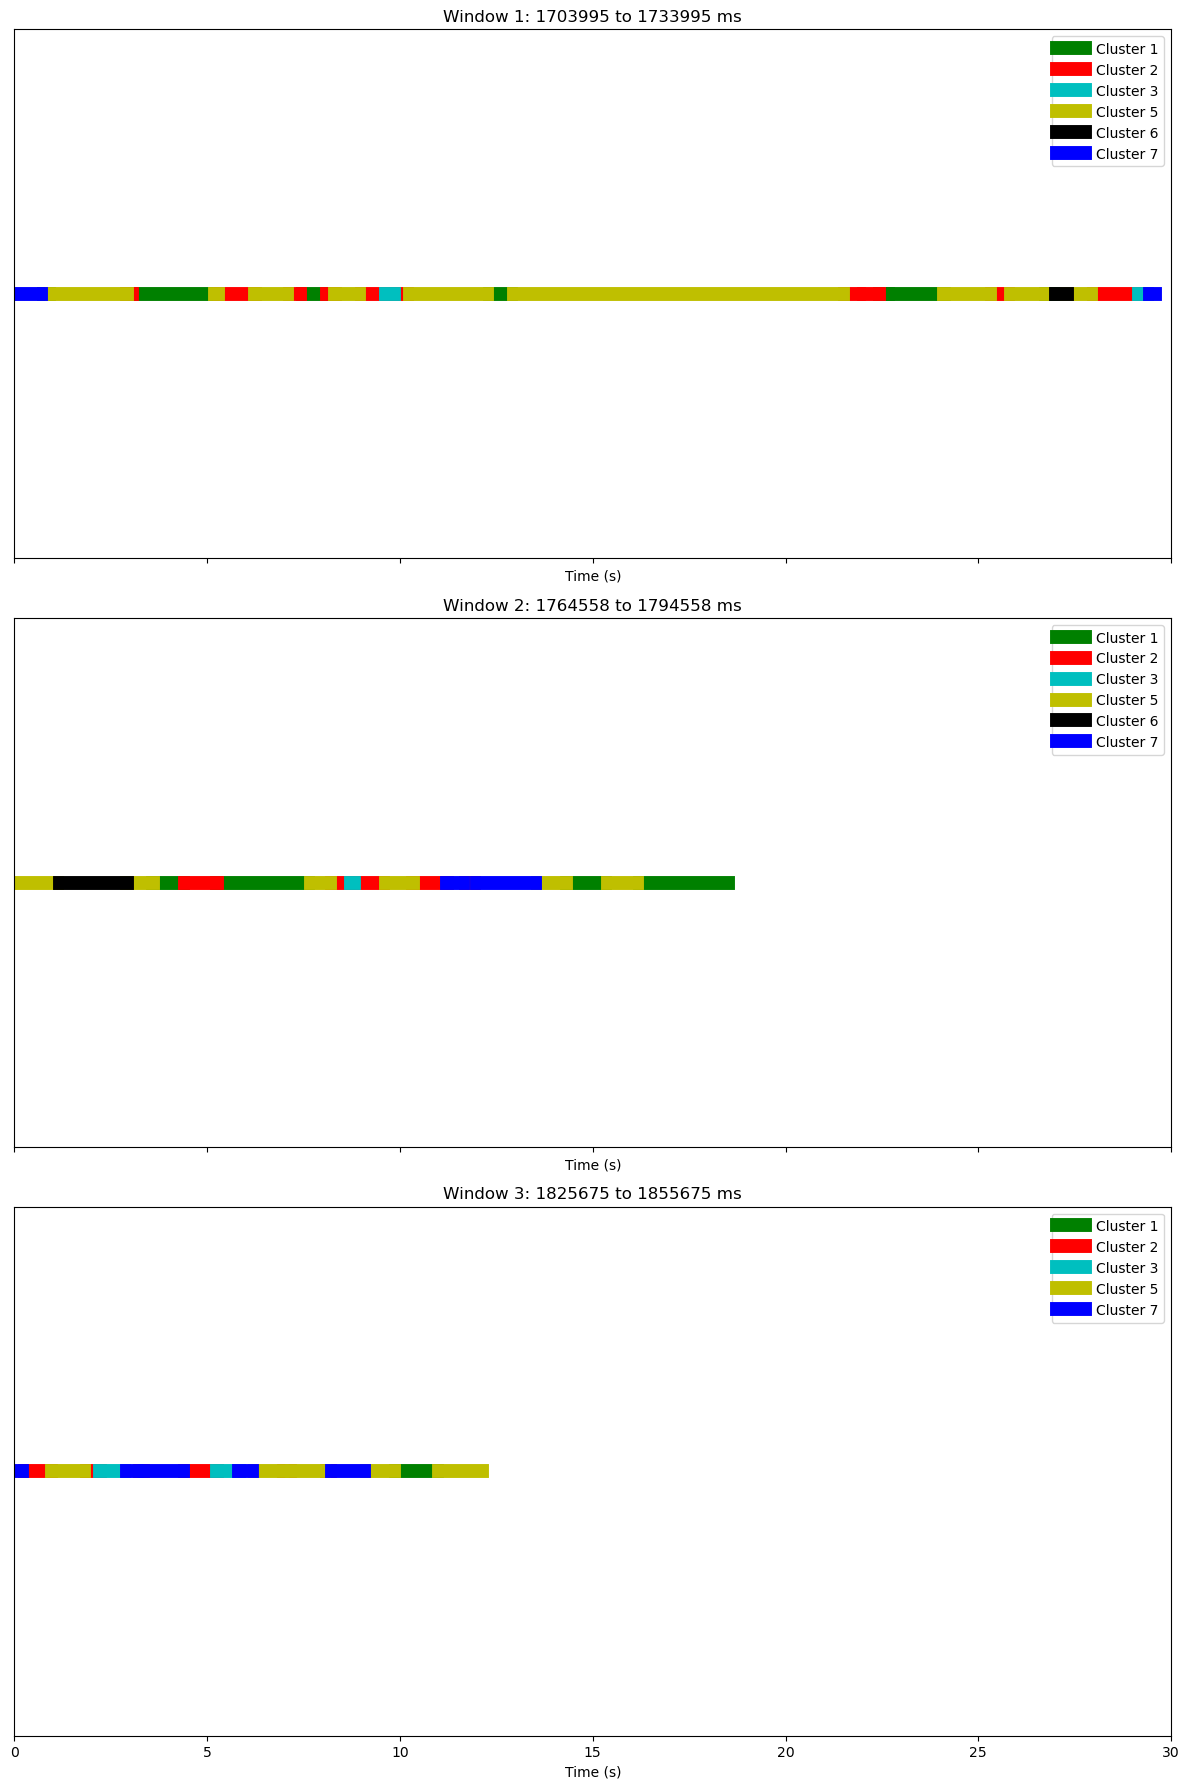

Window: 1703995 to 1733995
Window: 1764558 to 1794558
Window: 1825675 to 1855675


In [9]:
# Finding the lowest timestamp
min_timestamp = min(min(ranges[:, 0]) for ranges in rec1.values())

# Function to find the next starting point for the window, modified to calculate from the end of the last window
def find_next_start(current_start, all_timestamps, gap):
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the clusters
all_starts = np.concatenate([ranges[:, 0] for ranges in rec1.values()])

# Calculate dynamic windows starting directly from the minimum timestamp
dynamic_windows = [(min_timestamp, min_timestamp + 30000)]  # Set the first window directly
current_end = dynamic_windows[0][1]  # The end of the first window

# Find subsequent windows
for _ in range(2):  # Already have one window, only find two more
    next_start = find_next_start(current_end, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_end = next_start + 30000
    else:
        break  # Break if no next start is found

# Plotting code unchanged, assumes cluster_colors and other variables are defined as previously mentioned
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
ms_to_s = 1000
for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False
    for key in sorted(rec1, key=int):
        ranges = rec1[key]
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / ms_to_s
                plot_end = (min(end, window_end) - window_start) / ms_to_s
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], linewidth=10, label=f"Cluster {key}")
                data_present = True
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# Print dynamic window definitions for verification
for window in dynamic_windows:
    print(f"Window: {window[0]} to {window[1]}")

In [10]:
1794558 - 1764558

30000

In [23]:
window2 = all_starts[all_starts > 1764558]

In [24]:
window2 = window2[window2 < 1794558]

In [25]:
max(window2)

np.int64(1780773)

In [26]:
1794558 - 1764558

30000

In [27]:
1780773 - 1794558

-13785

In [28]:
(1794558 - 1780773) / 3000

4.595

In [32]:
all_stops = np.concatenate([ranges[:, 1] for ranges in rec1.values()])

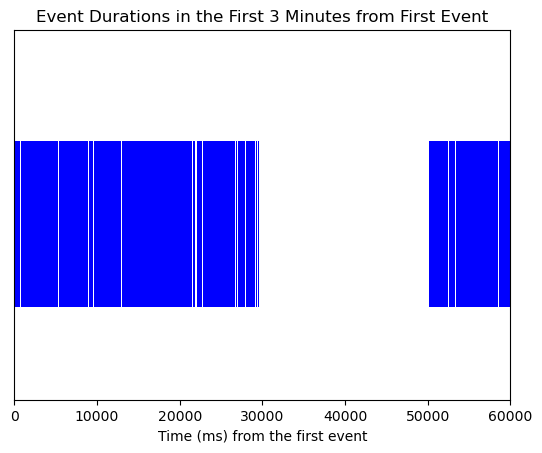

In [40]:
# Define the first timestamp and the end of the three-minute window
initial_timestamp = all_starts.min()
time_limit = initial_timestamp + 180000  # 3 minutes in milliseconds after the first event starts

# Filter indices where starts and stops are within the first 3-minute window
valid_indices = (all_starts >= initial_timestamp) & (all_starts <= time_limit) & (all_stops <= time_limit)

# Apply the filter
filtered_starts = all_starts[valid_indices]
filtered_stops = all_stops[valid_indices]

# Calculate durations and plot
durations = filtered_stops - filtered_starts
fig, ax = plt.subplots()
for start, duration in zip(filtered_starts, durations):
    relative_start = start - initial_timestamp
    ax.broken_barh([(relative_start, duration)], (10, 9), facecolors='blue')

ax.set_ylim(5, 25)
ax.set_xlim(0, 60000)  # This limits the x-axis to 180,000 ms (3 minutes)
ax.set_xlabel('Time (ms) from the first event')
ax.set_yticks([])
ax.set_title('Event Durations in the First 3 Minutes from First Event')

plt.show()

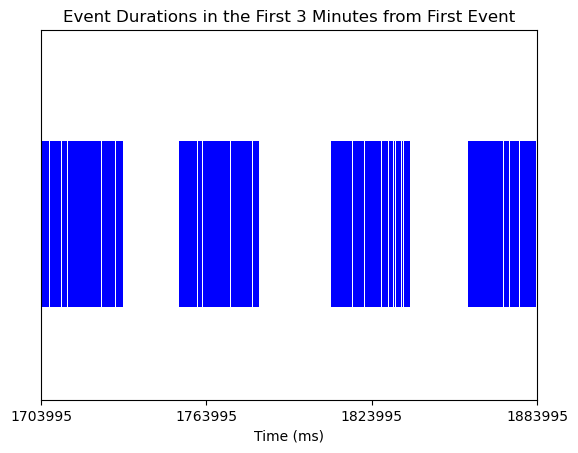

In [41]:
# Define the first timestamp and the end of the three-minute window
initial_timestamp = all_starts.min()
time_limit = initial_timestamp + 180000  # 3 minutes in milliseconds after the first event starts

# Filter indices where starts and stops are within the first 3-minute window
valid_indices = (all_starts >= initial_timestamp) & (all_starts <= time_limit) & (all_stops <= time_limit)

# Apply the filter
filtered_starts = all_starts[valid_indices]
filtered_stops = all_stops[valid_indices]

# Calculate durations and plot
durations = filtered_stops - filtered_starts
fig, ax = plt.subplots()
for start, duration in zip(filtered_starts, durations):
    ax.broken_barh([(start, duration)], (10, 9), facecolors='blue')

ax.set_ylim(5, 25)
ax.set_xlim(initial_timestamp, initial_timestamp + 180000)  # Adjusted to actual timestamps
ax.set_xlabel('Time (ms)')
ax.set_yticks([])
ax.set_title('Event Durations in the First 3 Minutes from First Event')

# Customize x-axis to show more meaningful tick labels
ax.set_xticks(np.linspace(initial_timestamp, initial_timestamp + 180000, 4))
ax.set_xticklabels([f'{int(tick)}' for tick in np.linspace(initial_timestamp, initial_timestamp + 180000, 4)])

plt.show()

In [42]:
sorted(all_starts)[0]

np.int64(1703995)

In [43]:
all_starts_0 = all_starts - 1703994

In [46]:
all_stops_0 = all_stops - 1703994

In [50]:
rec1_0 = rec1.copy()
for key in rec1_0:
    rec1_0[key] -= 1703994

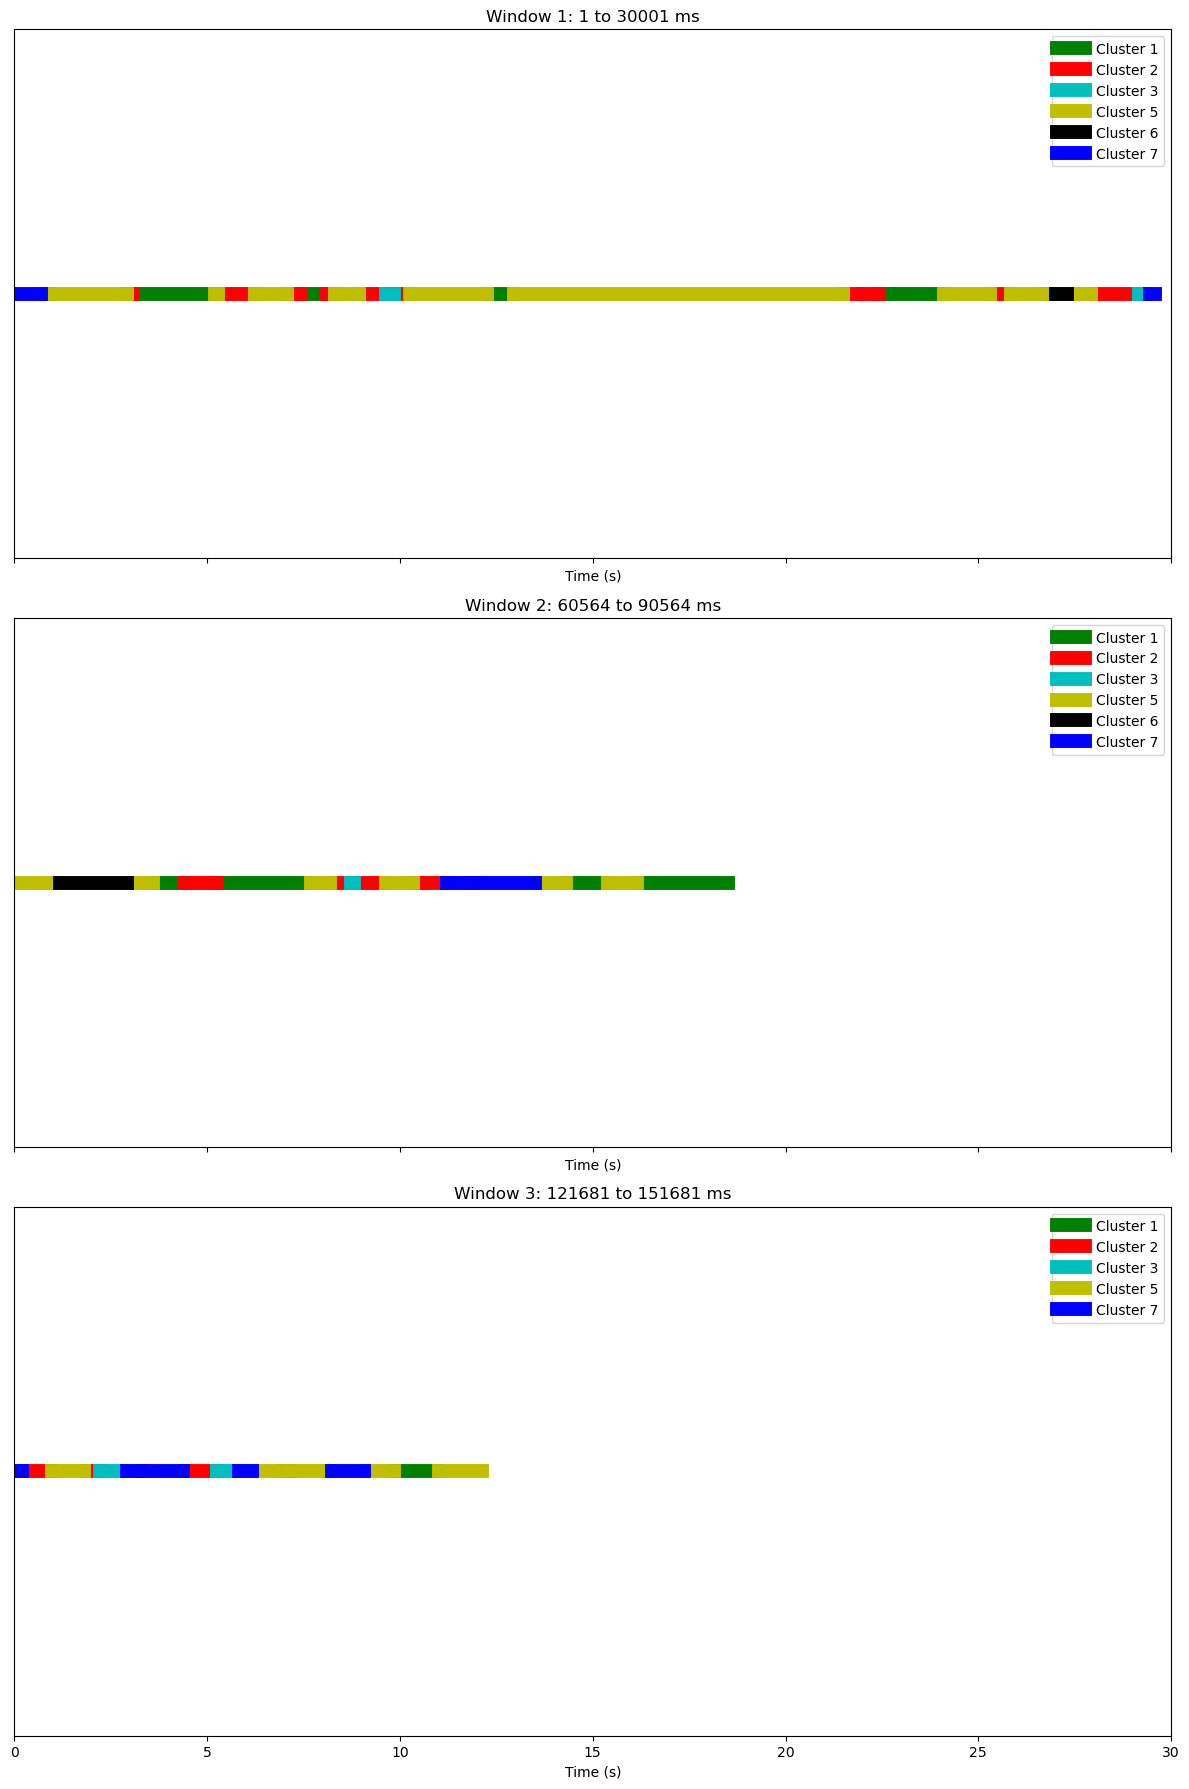

Window: 1 to 30001
Window: 60564 to 90564
Window: 121681 to 151681


In [51]:
# Finding the lowest timestamp
min_timestamp = min(min(ranges[:, 0]) for ranges in rec1_0.values())

# Function to find the next starting point for the window, modified to calculate from the end of the last window
def find_next_start(current_start, all_timestamps, gap):
    for timestamp in sorted(all_timestamps):
        if timestamp > current_start + gap:
            return timestamp
    return None  # Return None if no valid start is found

# Gather all start timestamps from the clusters
all_starts = np.concatenate([ranges[:, 0] for ranges in rec1_0.values()])

# Calculate dynamic windows starting directly from the minimum timestamp
dynamic_windows = [(min_timestamp, min_timestamp + 30000)]  # Set the first window directly
current_end = dynamic_windows[0][1]  # The end of the first window

# Find subsequent windows
for _ in range(2):  # Already have one window, only find two more
    next_start = find_next_start(current_end, all_starts, 30100)
    if next_start:
        dynamic_windows.append((next_start, next_start + 30000))
        current_end = next_start + 30000
    else:
        break  # Break if no next start is found

# Plotting code unchanged, assumes cluster_colors and other variables are defined as previously mentioned
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
ms_to_s = 1000
for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False
    for key in sorted(rec1_0, key=int):
        ranges = rec1_0[key]
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / ms_to_s
                plot_end = (min(end, window_end) - window_start) / ms_to_s
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], linewidth=10, label=f"Cluster {key}")
                data_present = True
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num+1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# Print dynamic window definitions for verification
for window in dynamic_windows:
    print(f"Window: {window[0]} to {window[1]}")

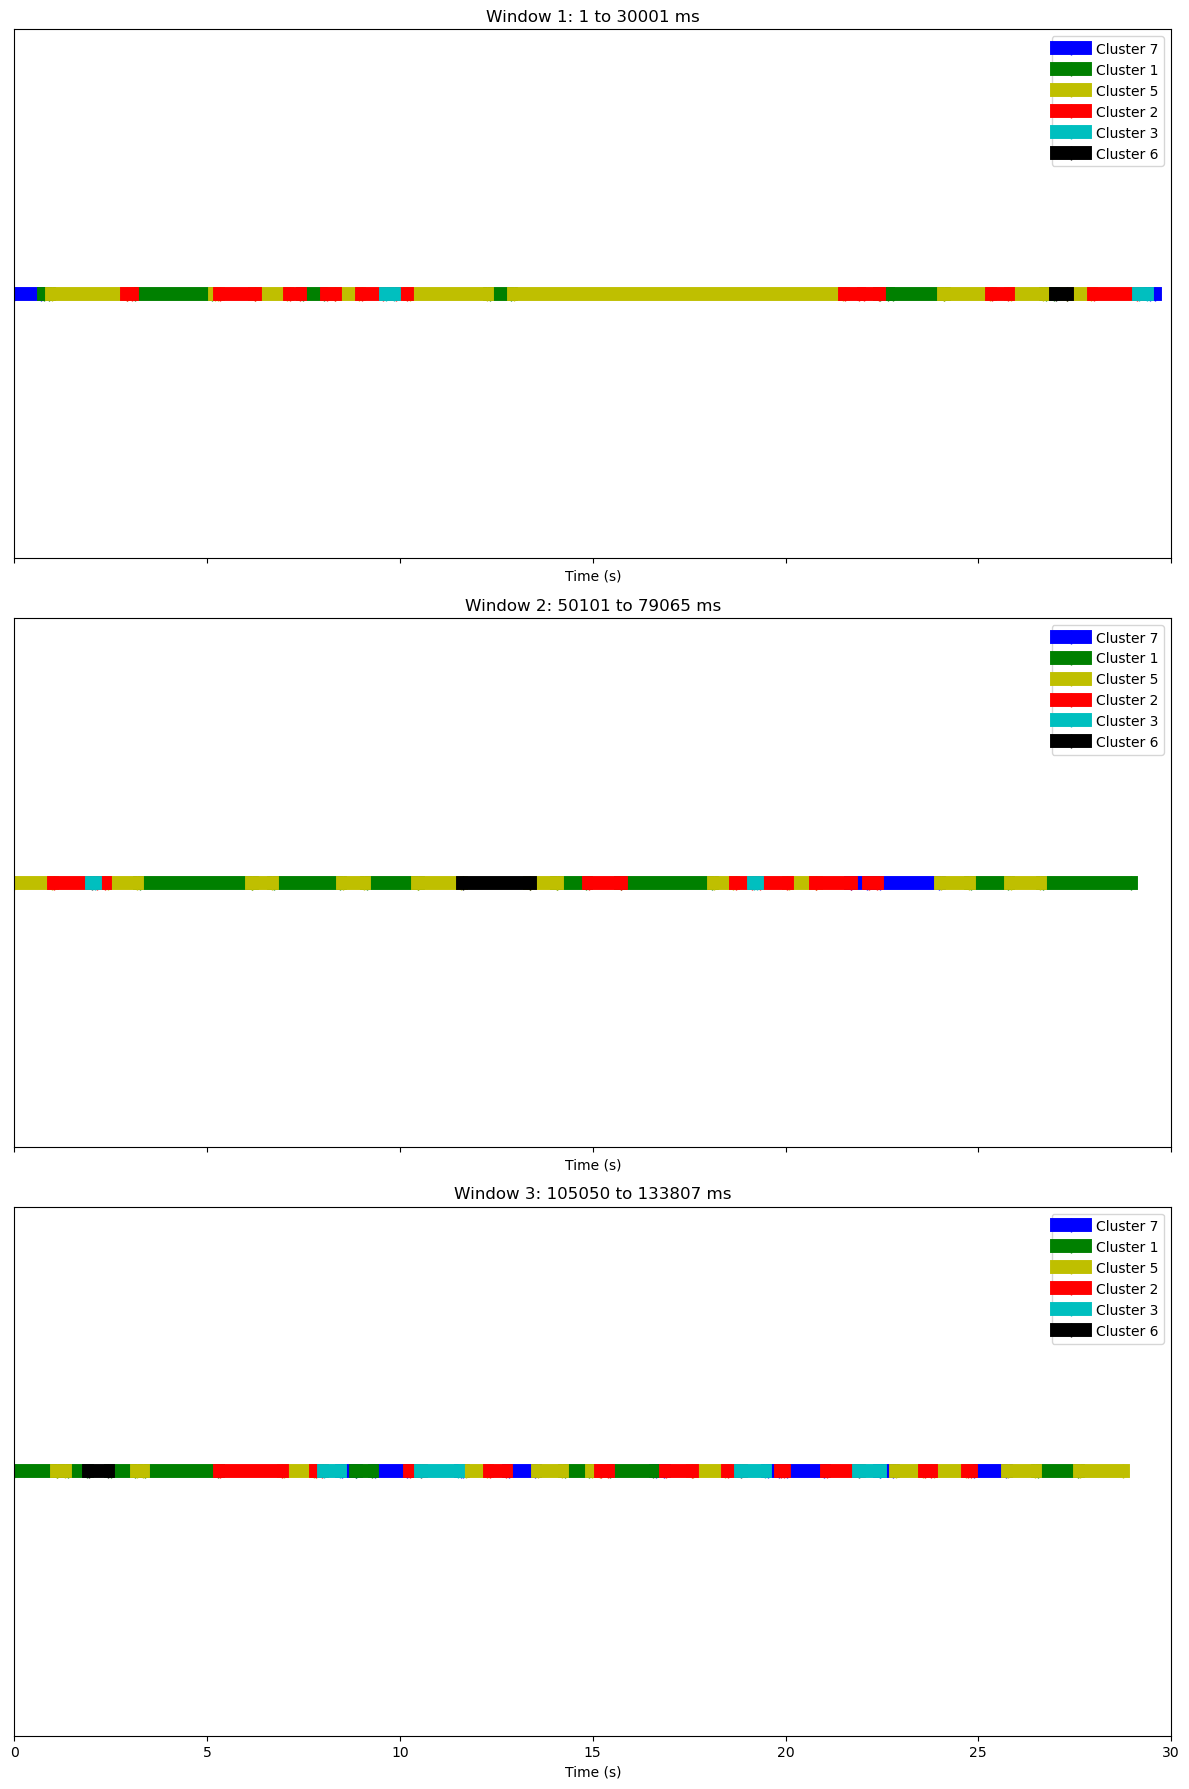

Window: 1 to 30001
Window: 50101 to 79065
Window: 105050 to 133807


In [52]:
def find_next_window(start_time, all_timestamps, all_ranges, gap):
    # Find the next start time that is greater than the given start_time
    next_start = min([t for t in all_timestamps if t > start_time], default=None)
    if next_start is None:
        return None, None
    
    # Determine the maximum end time that doesn't exceed next_start + gap
    potential_ends = [end for start, end in all_ranges if start >= next_start and end <= next_start + gap]
    if not potential_ends:
        return next_start, next_start + gap  # Extend to the full window length if no end within range
    next_end = max(potential_ends)
    return next_start, next_end

# Gather all ranges flattened into a single list
all_ranges = [r for ranges in rec1_0.values() for r in ranges]
all_starts = np.array([start for start, _ in all_ranges])
all_ends = np.array([end for _, end in all_ranges])

# Initialize the first window starting from the minimum start time
min_timestamp = all_starts.min()
dynamic_windows = [(min_timestamp, min(min_timestamp + 30000, all_ends.max()))]

# Find subsequent windows, iterating until no more valid windows are found
while len(dynamic_windows) < 3:
    current_end = dynamic_windows[-1][1]
    next_start, next_end = find_next_window(current_end, all_starts, all_ranges, 30100)
    if next_start is None:
        break
    dynamic_windows.append((next_start, next_end))

# Plotting the windows
fig, axes = plt.subplots(len(dynamic_windows), 1, figsize=(12, 18), sharex=True)
ms_to_s = 1000
for window_num, (window_start, window_end) in enumerate(dynamic_windows):
    ax = axes[window_num]
    data_present = False
    for key, ranges in rec1_0.items():
        for start, end in ranges:
            if start < window_end and end > window_start:
                plot_start = (max(start, window_start) - window_start) / ms_to_s
                plot_end = (min(end, window_end) - window_start) / ms_to_s
                ax.plot([plot_start, plot_end], [0, 0], marker='|', color=cluster_colors[key], linewidth=10, markersize=10, label=f"Cluster {key}")
                data_present = True
    ax.set_xlim(0, 30)
    ax.set_xlabel("Time (s)")
    ax.set_title(f"Window {window_num + 1}: {window_start} to {window_end} ms")
    ax.axes.yaxis.set_visible(False)
    if data_present:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')
plt.tight_layout()
plt.show()

# Print dynamic window definitions for verification
for window in dynamic_windows:
    print(f"Window: {window[0]} to {window[1]}")

In [55]:
window2 = sorted(all_starts[all_starts > 30000])

In [58]:
window2_ends = sorted(all_ends[all_ends > 28000])

In [57]:
50101+30000

80101

In [61]:
(79065-50101)/1000

28.964

In [75]:
# Using np.in1d to check for presence in array2
starts_in_stops = np.isin(all_starts, all_ends)

# Counting values of array1 that are in array2
count_start_in_stop = np.sum(starts_in_stops)

# Counting values of array1 that are not in array2
count_start_not_in_stop = np.sum(~starts_in_stops)  # or len(array1) - count_in_array2

# Displaying the results
print(f'array1 in array2: {count_start_in_stop}')
print(f'array1 not in array2: {count_start_not_in_stop}')

array1 in array2: 147
array1 not in array2: 538


In [98]:
# Initialize a dictionary to store total counts for each cluster ID
cluster_counts = {}

# Iterate over each recording in the dictionary
for recording in timestamp_dicts.values():
    for cluster_id, ranges in recording.items():
        # Sum the count for each cluster
        if cluster_id in cluster_counts:
            cluster_counts[cluster_id] += len(ranges)
        else:
            cluster_counts[cluster_id] = len(ranges)

# Displaying the combined counts for each cluster
print(cluster_counts)

{'7': 542, '1': 550, '5': 722, '2': 773, '3': 553, '6': 267, '0': 121, '4': 1}


In [100]:
def find_next_window(start_time, all_timestamps, all_ranges, gap):
    # Find the next start time that is greater than the given start_time
    next_start = min([t for t in all_timestamps if t > start_time], default=None)
    if next_start is None:
        return None, None
    
    # Determine the maximum end time that doesn't exceed next_start + gap
    potential_ends = [end for start, end in all_ranges if start >= next_start and end <= next_start + gap]
    if not potential_ends:
        return next_start, next_start + gap  # Extend to the full window length if no end within range
    next_end = max(potential_ends)
    return next_start, next_end

# Process each recording in timestamp_dicts
windowed_events = {}

for recording_key, clusters in timestamp_dicts.items():
    # Prepare data arrays
    all_ranges = []
    all_cluster_ids = []
    for cluster_id, times in clusters.items():
        for start_end in times:
            all_ranges.append(start_end)
            all_cluster_ids.append(cluster_id)
    
    all_starts = np.array([r[0] for r in all_ranges])
    all_ends = np.array([r[1] for r in all_ranges])
    
    # Sort ranges by start times for processing order
    sorted_indices = np.argsort(all_starts)
    all_starts = all_starts[sorted_indices]
    all_ends = all_ends[sorted_indices]
    all_cluster_ids = [all_cluster_ids[i] for i in sorted_indices]
    
    # Initialize windows
    min_timestamp = all_starts.min()
    dynamic_windows = [(min_timestamp, min(min_timestamp + 30000, all_ends.max()))]
    
    # Find subsequent windows
    current_end = dynamic_windows[-1][1]
    while True:
        next_start, next_end = find_next_window(current_end, all_starts, list(zip(all_starts, all_ends)), 30100)
        if next_start is None:
            break
        dynamic_windows.append((next_start, next_end))
        current_end = next_end

    # Map clusters to windows
    windows_dict = {}
    for window_num, (window_start, window_end) in enumerate(dynamic_windows):
        clusters_in_window = []
        for idx, (start, end) in enumerate(zip(all_starts, all_ends)):
            if start >= window_start and end <= window_end:
                clusters_in_window.append(all_cluster_ids[idx])
        
        if clusters_in_window:  # Only store windows with data
            windows_dict[f"Window {window_num + 1}"] = clusters_in_window

    windowed_events[recording_key] = windows_dict

# Optionally, print the dictionary to verify
for recording, windows in windowed_events.items():
    print(f"{recording}:")
    for window, clusters in windows.items():
        print(f"  {window}: {clusters}")

20240320_171038_alone_comp_subj_4-2:
  Window 1: ['7', '1', '5', '2', '1', '5', '2', '5', '2', '1', '2', '5', '2', '3', '2', '5', '1', '5', '2', '2', '1', '1', '5', '2', '5', '1', '6', '5', '2', '3', '7']
  Window 2: ['5', '2', '3', '2', '5', '1', '5', '1', '5', '1', '5', '6', '5', '1', '2', '1', '5', '2', '3', '2', '5', '2', '7', '2', '7', '5', '1', '5', '1']
  Window 3: ['1', '5', '1', '6', '1', '5', '1', '2', '5', '2', '3', '7', '1', '7', '2', '3', '7', '5', '2', '7', '5', '1', '5', '2', '1', '7', '2', '5', '2', '3', '7', '2', '7', '2', '3', '7', '5', '2', '5', '2', '7', '5', '1', '5']
  Window 4: ['3', '2', '5', '1', '5', '1', '5', '6', '1', '5', '1', '5', '1', '6', '5', '6', '5', '1', '6', '5', '2', '5', '1', '5', '2', '3', '2', '5', '1', '5', '1', '5', '1', '5']
  Window 5: ['1', '5', '1', '5', '1', '6', '5', '2', '3', '7', '5', '1', '6', '1', '5', '1', '5', '1', '6', '1', '6', '1', '6', '1', '5']
  Window 6: ['2', '1', '2', '3', '2', '3', '5', '1', '5', '1', '5', '1', '5', '1', 

In [102]:
def combine_intervals(ranges):
    """Combine intervals that are within 250 milliseconds of each other."""
    if ranges.size == 0:
        return ranges
    # Sort ranges based on the start times
    sorted_ranges = np.array(sorted(ranges, key=lambda x: x[0]))
    combined = [sorted_ranges[0]]

    for current in sorted_ranges[1:]:
        last = combined[-1]
        # If the current start is within 250 ms of the last end, combine them
        if current[0] - last[1] <= 250:
            combined[-1] = [last[0], max(last[1], current[1])]
        else:
            combined.append(current)

    return np.array(combined)

def remove_short_intervals(ranges):
    """Remove intervals that are less than 250 milliseconds long."""
    return np.array([interval for interval in ranges if interval[1] - interval[0] >= 250])

def process_timestamps_nested(timestamp_dicts):
    timestamp_dicts_cut = {}
    for date_key, clusters in timestamp_dicts.items():
        timestamp_dicts_cut[date_key] = {}
        for cluster_key, intervals in clusters.items():
            intervals = np.array(intervals)  # Ensure intervals is a numpy array
            if intervals.size > 0 and intervals.ndim == 2:  # Check if there are any intervals and it's 2-dimensional
                combined = combine_intervals(intervals)
                cleaned = remove_short_intervals(combined)
                timestamp_dicts_cut[date_key][cluster_key] = cleaned
            else:
                timestamp_dicts_cut[date_key][cluster_key] = np.array([])  # Handle empty or malformed input case
    return timestamp_dicts_cut

# Assuming timestamp_dicts is defined and filled with your data
timestamp_dicts_cut = process_timestamps_nested(timestamp_dicts)

In [103]:
def find_next_window(start_time, all_timestamps, all_ranges, gap):
    # Find the next start time that is greater than the given start_time
    next_start = min([t for t in all_timestamps if t > start_time], default=None)
    if next_start is None:
        return None, None
    
    # Determine the maximum end time that doesn't exceed next_start + gap
    potential_ends = [end for start, end in all_ranges if start >= next_start and end <= next_start + gap]
    if not potential_ends:
        return next_start, next_start + gap  # Extend to the full window length if no end within range
    next_end = max(potential_ends)
    return next_start, next_end

# Process each recording in timestamp_dicts_cut
windowed_events = {}

for recording_key, clusters in timestamp_dicts_cut.items():
    # Prepare data arrays
    all_ranges = []
    all_cluster_ids = []
    for cluster_id, times in clusters.items():
        for start_end in times:
            all_ranges.append(start_end)
            all_cluster_ids.append(cluster_id)
    
    all_starts = np.array([r[0] for r in all_ranges])
    all_ends = np.array([r[1] for r in all_ranges])
    
    # Sort ranges by start times for processing order
    sorted_indices = np.argsort(all_starts)
    all_starts = all_starts[sorted_indices]
    all_ends = all_ends[sorted_indices]
    all_cluster_ids = [all_cluster_ids[i] for i in sorted_indices]
    
    # Initialize windows
    min_timestamp = all_starts.min()
    dynamic_windows = [(min_timestamp, min(min_timestamp + 30000, all_ends.max()))]
    
    # Find subsequent windows
    current_end = dynamic_windows[-1][1]
    while True:
        next_start, next_end = find_next_window(current_end, all_starts, list(zip(all_starts, all_ends)), 30100)
        if next_start is None:
            break
        dynamic_windows.append((next_start, next_end))
        current_end = next_end

    # Map clusters to windows
    windows_dict = {}
    for window_num, (window_start, window_end) in enumerate(dynamic_windows):
        clusters_in_window = []
        for idx, (start, end) in enumerate(zip(all_starts, all_ends)):
            if start >= window_start and end <= window_end:
                clusters_in_window.append(all_cluster_ids[idx])
        
        if clusters_in_window:  # Only store windows with data
            windows_dict[f"Window {window_num + 1}"] = clusters_in_window

    windowed_events[recording_key] = windows_dict

# Optionally, print the dictionary to verify
for recording, windows in windowed_events.items():
    print(f"{recording}:")
    for window, clusters in windows.items():
        print(f"  {window}: {clusters}")

20240320_171038_alone_comp_subj_4-2:
  Window 1: ['7', '5', '1', '2', '5', '2', '1', '5', '2', '2', '5', '1', '5', '2', '1', '5', '2', '5', '6', '5', '2']
  Window 2: ['5', '2', '5', '1', '5', '1', '5', '1', '5', '6', '5', '1', '2', '1', '5', '2', '5', '2', '7', '7', '5', '1', '5', '1']
  Window 3: ['1', '1', '6', '1', '1', '2', '5', '3', '7', '1', '7', '2', '3', '5', '2', '7', '5', '1', '1', '2', '5', '2', '3', '7', '2', '3', '7', '5', '5', '7', '5', '1', '5']
  Window 4: ['3', '2', '5', '1', '5', '1', '1', '5', '1', '5', '1', '6', '5', '6', '1', '6', '5', '2', '1', '5', '2', '5', '1', '5', '1', '5', '1']
  Window 5: ['1', '5', '1', '5', '1', '6', '5', '2', '5', '1', '6', '1', '5', '1', '5', '1', '6', '1', '6', '1', '6', '1', '5']
  Window 6: ['1', '2', '3', '2', '3', '5', '1', '5', '1', '5', '1', '5', '1', '6', '1', '6', '5', '6', '5', '2', '1', '5']
  Window 7: ['5', '2', '3', '7', '5', '1', '2', '3', '5', '7', '5', '1', '5', '1', '2', '3', '7', '7', '2', '3', '7', '5', '3', '5', '5

In [104]:
from collections import defaultdict

# First calculate total counts without cluster '4'
cluster_counts = {k: v for k, v in cluster_counts.items() if k != '4'}

# Initialize transition counts
transition_counts = defaultdict(lambda: defaultdict(int))

# Gather all sequences from windowed_events
for recording, windows in windowed_events.items():
    for window, clusters in windows.items():
        filtered_clusters = [c for c in clusters if c != '4']  # Remove cluster '4'
        for i in range(len(filtered_clusters) - 1):
            current_cluster = filtered_clusters[i]
            next_cluster = filtered_clusters[i + 1]
            transition_counts[current_cluster][next_cluster] += 1

# Convert to probabilities
transition_probabilities = defaultdict(dict)
for cluster_i, transitions in transition_counts.items():
    total_transitions = sum(transitions.values())
    for cluster_j, count in transitions.items():
        transition_probabilities[cluster_i][cluster_j] = count / total_transitions

# Printing transition probabilities
for cluster_i, transitions in transition_probabilities.items():
    print(f"Transitions from {cluster_i}:")
    for cluster_j, prob in transitions.items():
        print(f"  to {cluster_j}: {prob:.4f}")

Transitions from 7:
  to 5: 0.2650
  to 7: 0.0342
  to 1: 0.1225
  to 2: 0.2080
  to 0: 0.1111
  to 3: 0.2593
Transitions from 5:
  to 1: 0.3606
  to 2: 0.3322
  to 6: 0.1068
  to 3: 0.0768
  to 5: 0.0367
  to 7: 0.0851
  to 0: 0.0017
Transitions from 1:
  to 2: 0.1787
  to 5: 0.4570
  to 1: 0.0339
  to 6: 0.2738
  to 7: 0.0407
  to 3: 0.0158
Transitions from 2:
  to 5: 0.2475
  to 1: 0.1116
  to 2: 0.0345
  to 7: 0.1075
  to 3: 0.4909
  to 6: 0.0020
  to 0: 0.0061
Transitions from 6:
  to 5: 0.4844
  to 1: 0.4635
  to 2: 0.0156
  to 6: 0.0312
  to 3: 0.0052
Transitions from 3:
  to 7: 0.3626
  to 5: 0.1709
  to 2: 0.2979
  to 1: 0.0231
  to 0: 0.1316
  to 3: 0.0139
Transitions from 0:
  to 7: 0.6020
  to 3: 0.3571
  to 2: 0.0102
  to 5: 0.0204
  to 0: 0.0102


In [105]:
from scipy.stats import chi2_contingency

# Expected probabilities based on independent cluster occurrences
total_counts = sum(cluster_counts.values())
expected_probabilities = {k: v / total_counts for k, v in cluster_counts.items()}

# Build observed and expected matrices for chi-squared test
observed = []
expected = []

clusters_list = list(cluster_counts.keys())  # List of clusters
for cluster_i in clusters_list:
    observed_row = []
    expected_row = []
    for cluster_j in clusters_list:
        observed_row.append(transition_counts[cluster_i].get(cluster_j, 0))
        expected_count = expected_probabilities[cluster_j] * sum(transition_counts[cluster_i].values())
        expected_row.append(expected_count)
    observed.append(observed_row)
    expected.append(expected_row)

chi2, p_value, _, _ = chi2_contingency(observed, correction=False)

# Display results
print(f"Chi-squared Test Results: Chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("The transition probabilities are statistically significant.")
else:
    print("No significant difference in transition probabilities.")

Chi-squared Test Results: Chi2 = 2364.933418835518, p-value = 0.0
The transition probabilities are statistically significant.


In [106]:
total_counts

3528

In [107]:
expected_probabilities

{'7': 0.1536281179138322,
 '1': 0.15589569160997732,
 '5': 0.2046485260770975,
 '2': 0.21910430839002268,
 '3': 0.15674603174603174,
 '6': 0.07568027210884354,
 '0': 0.03429705215419501}

In [108]:
cluster_counts

{'7': 542, '1': 550, '5': 722, '2': 773, '3': 553, '6': 267, '0': 121}

In [110]:
expected_array = np.array(expected)
min_expected_frequency = expected_array.min()

print(f"Minimum expected frequency in the contingency table: {min_expected_frequency}")

if min_expected_frequency < 5:
    print("Some expected frequencies are less than 5, which might invalidate the chi-squared test results.")
else:
    print("All expected frequencies are 5 or greater, supporting the validity of the chi-squared test results.")


Minimum expected frequency in the contingency table: 3.361111111111111
Some expected frequencies are less than 5, which might invalidate the chi-squared test results.


In [111]:
from scipy.stats import chi2_contingency

# Assuming 'observed' is your 7x7 transition matrix
observed = np.array(observed)  # Make sure it's a NumPy array

# Run a Monte Carlo simulation of the chi-squared test
chi2, p_value, _, _ = chi2_contingency(observed, lambda_="log-likelihood", correction=False)

print(f"Chi-squared Statistic: {chi2}, P-value (Monte Carlo): {p_value}")

Chi-squared Statistic: 2354.2090351936913, P-value (Monte Carlo): 0.0


In [112]:
observed

array([[ 12,  43,  93,  73,  91,   0,  39],
       [ 18,  15, 202,  79,   7, 121,   0],
       [ 51, 216,  22, 199,  46,  64,   1],
       [ 53,  55, 122,  17, 242,   1,   3],
       [157,  10,  74, 129,   6,   0,  57],
       [  0,  89,  93,   3,   1,   6,   0],
       [ 59,   0,   2,   1,  35,   0,   1]])

In [121]:
np.around(expected, decimals=2)

array([[ 53.92,  54.72,  71.83,  76.91,  55.02,  26.56,  12.04],
       [ 67.9 ,  68.91,  90.45,  96.84,  69.28,  33.45,  15.16],
       [ 92.02,  93.38, 122.58, 131.24,  93.89,  45.33,  20.54],
       [ 75.74,  76.86, 100.89, 108.02,  77.28,  37.31,  16.91],
       [ 66.52,  67.5 ,  88.61,  94.87,  67.87,  32.77,  14.85],
       [ 29.5 ,  29.93,  39.29,  42.07,  30.1 ,  14.53,   6.59],
       [ 15.06,  15.28,  20.06,  21.47,  15.36,   7.42,   3.36]])

In [123]:
np.sum(expected)

np.float64(2608.0)

In [124]:
np.sum(observed)

np.int64(2608)

In [125]:
from scipy.stats import norm

# Calculate residuals
residuals = (np.array(observed) - np.array(expected)) / np.sqrt(np.array(expected))

# Calculate p-values from residuals
p_values = 2 * (1 - norm.cdf(np.abs(residuals)))

# Adjust for multiple comparisons using the Bonferroni method
alpha = 0.05
num_tests = len(clusters_list) * len(clusters_list)
bonferroni_alpha = alpha / num_tests

# Identify significant residuals
significant_mask = p_values < bonferroni_alpha
significant_transitions = np.argwhere(significant_mask)

# Print significant transitions
print("Significant transitions (from, to):")
for idx in significant_transitions:
    from_cluster = clusters_list[idx[0]]
    to_cluster = clusters_list[idx[1]]
    print(f"From Cluster {from_cluster} to Cluster {to_cluster} (p={p_values[idx[0], idx[1]]:.4f})")

Significant transitions (from, to):
From Cluster 7 to Cluster 7 (p=0.0000)
From Cluster 7 to Cluster 3 (p=0.0000)
From Cluster 7 to Cluster 6 (p=0.0000)
From Cluster 7 to Cluster 0 (p=0.0000)
From Cluster 1 to Cluster 7 (p=0.0000)
From Cluster 1 to Cluster 1 (p=0.0000)
From Cluster 1 to Cluster 5 (p=0.0000)
From Cluster 1 to Cluster 3 (p=0.0000)
From Cluster 1 to Cluster 6 (p=0.0000)
From Cluster 1 to Cluster 0 (p=0.0001)
From Cluster 5 to Cluster 7 (p=0.0000)
From Cluster 5 to Cluster 1 (p=0.0000)
From Cluster 5 to Cluster 5 (p=0.0000)
From Cluster 5 to Cluster 2 (p=0.0000)
From Cluster 5 to Cluster 3 (p=0.0000)
From Cluster 5 to Cluster 0 (p=0.0000)
From Cluster 2 to Cluster 2 (p=0.0000)
From Cluster 2 to Cluster 3 (p=0.0000)
From Cluster 2 to Cluster 6 (p=0.0000)
From Cluster 2 to Cluster 0 (p=0.0007)
From Cluster 3 to Cluster 7 (p=0.0000)
From Cluster 3 to Cluster 1 (p=0.0000)
From Cluster 3 to Cluster 2 (p=0.0005)
From Cluster 3 to Cluster 3 (p=0.0000)
From Cluster 3 to Cluster 6 

Chi-squared Test Results: Chi2 = 2364.933418835518, p-value = 0.0
The transition probabilities are statistically significant.
Observed Transition Matrix:
[12, 43, 93, 73, 91, 0, 39]
[18, 15, 202, 79, 7, 121, 0]
[51, 216, 22, 199, 46, 64, 1]
[53, 55, 122, 17, 242, 1, 3]
[157, 10, 74, 129, 6, 0, 57]
[0, 89, 93, 3, 1, 6, 0]
[59, 0, 2, 1, 35, 0, 1]

Expected Transition Matrix:
[53.92, 54.72, 71.83, 76.91, 55.02, 26.56, 12.04]
[67.9, 68.91, 90.45, 96.84, 69.28, 33.45, 15.16]
[92.02, 93.38, 122.58, 131.24, 93.89, 45.33, 20.54]
[75.74, 76.86, 100.89, 108.02, 77.28, 37.31, 16.91]
[66.52, 67.5, 88.61, 94.87, 67.87, 32.77, 14.85]
[29.5, 29.93, 39.29, 42.07, 30.1, 14.53, 6.59]
[15.06, 15.28, 20.06, 21.47, 15.36, 7.42, 3.36]


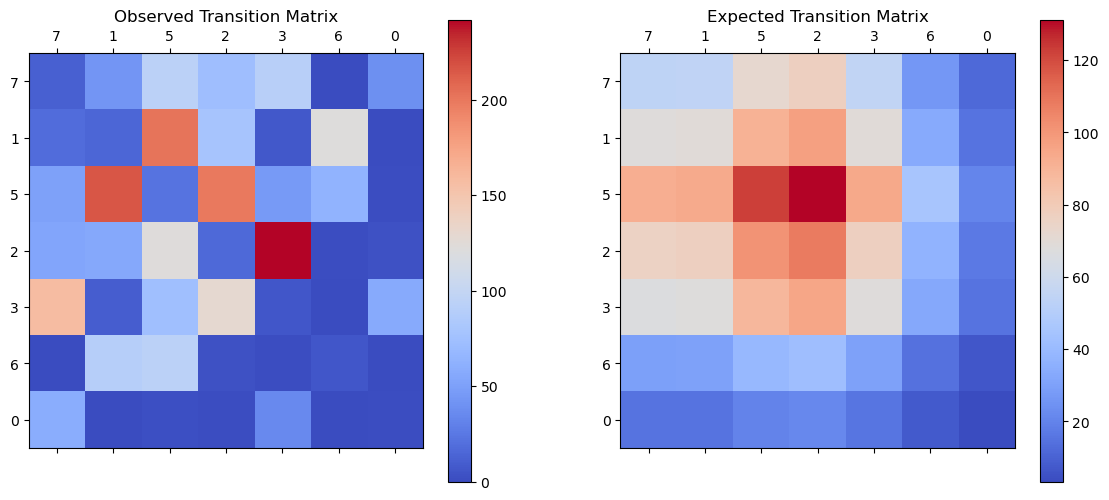

In [126]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Expected probabilities based on independent cluster occurrences
total_counts = sum(cluster_counts.values())
expected_probabilities = {k: v / total_counts for k, v in cluster_counts.items()}

# Build observed and expected matrices for chi-squared test
observed = []
expected = []

clusters_list = list(cluster_counts.keys())  # List of clusters
for cluster_i in clusters_list:
    observed_row = []
    expected_row = []
    for cluster_j in clusters_list:
        observed_count = transition_counts[cluster_i].get(cluster_j, 0)
        observed_row.append(observed_count)
        expected_count = expected_probabilities[cluster_j] * sum(transition_counts[cluster_i].values())
        expected_row.append(expected_count)
    observed.append(observed_row)
    expected.append(expected_row)

# Chi-squared test
chi2, p_value, _, _ = chi2_contingency(observed, correction=False)

# Display results
print(f"Chi-squared Test Results: Chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("The transition probabilities are statistically significant.")
else:
    print("No significant difference in transition probabilities.")

# Print observed and expected matrices
print("Observed Transition Matrix:")
for row in observed:
    print(row)

print("\nExpected Transition Matrix:")
for row in expected:
    print([round(num, 2) for num in row])

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot observed matrix
cax1 = ax1.matshow(observed, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('Observed Transition Matrix')
ax1.set_xticks(range(len(clusters_list)))
ax1.set_yticks(range(len(clusters_list)))
ax1.set_xticklabels(clusters_list)
ax1.set_yticklabels(clusters_list)

# Plot expected matrix
cax2 = ax2.matshow(expected, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('Expected Transition Matrix')
ax2.set_xticks(range(len(clusters_list)))
ax2.set_yticks(range(len(clusters_list)))
ax2.set_xticklabels(clusters_list)
ax2.set_yticklabels(clusters_list)

plt.show()

Chi-squared Test Results: Chi2 = 2364.933418835518, p-value = 0.0
The transition probabilities are statistically significant.


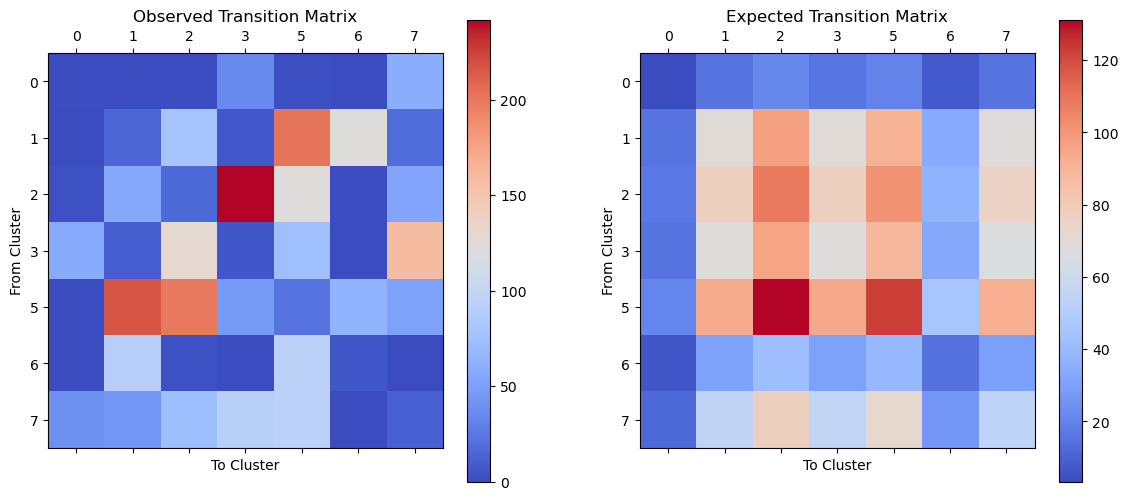

In [127]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Manually set the order of clusters
clusters_list = ['0', '1', '2', '3', '5', '6', '7']  # Ensure this list is ordered as desired

# Calculate total counts for expected probabilities
total_counts = sum(cluster_counts[cluster] for cluster in clusters_list)

# Calculate expected probabilities for each cluster
expected_probabilities = {cluster: cluster_counts[cluster] / total_counts for cluster in clusters_list}

# Initialize observed and expected matrices
observed = np.zeros((len(clusters_list), len(clusters_list)))
expected = np.zeros((len(clusters_list), len(clusters_list)))

# Fill observed and expected matrices
for i, cluster_i in enumerate(clusters_list):
    for j, cluster_j in enumerate(clusters_list):
        observed[i, j] = transition_counts[cluster_i].get(cluster_j, 0)
        expected[i, j] = expected_probabilities[cluster_j] * sum(transition_counts[cluster_i].values())

# Perform the chi-squared test
chi2, p_value, _, _ = chi2_contingency(observed, correction=False)

# Print results
print(f"Chi-squared Test Results: Chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("The transition probabilities are statistically significant.")
else:
    print("No significant difference in transition probabilities.")

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Observed transition matrix
cax1 = ax1.matshow(observed, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('Observed Transition Matrix')
ax1.set_xticks(range(len(clusters_list)))
ax1.set_yticks(range(len(clusters_list)))
ax1.set_xticklabels(clusters_list)
ax1.set_yticklabels(clusters_list)
ax1.set_xlabel('To Cluster')
ax1.set_ylabel('From Cluster')

# Expected transition matrix
cax2 = ax2.matshow(expected, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('Expected Transition Matrix')
ax2.set_xticks(range(len(clusters_list)))
ax2.set_yticks(range(len(clusters_list)))
ax2.set_xticklabels(clusters_list)
ax2.set_yticklabels(clusters_list)
ax2.set_xlabel('To Cluster')
ax2.set_ylabel('From Cluster')

plt.show()

In [128]:
clusters_list

['0', '1', '2', '3', '5', '6', '7']

In [136]:
# Create a new dictionary to store the merged window events
windowed_events_merged = {}

# Loop through each recording
for recording_key, windows in windowed_events.items():
    # Prepare a sub-dictionary for the current recording
    windowed_events_merged[recording_key] = {}
    
    # Loop through each window in the current recording
    for window_key, clusters in windows.items():
        # Initialize a new list to store clusters without consecutive duplicates
        filtered_clusters = []
        
        # Iterate through the list of clusters in the current window
        previous_cluster = None
        for cluster in clusters:
            if cluster != previous_cluster:
                filtered_clusters.append(cluster)
                previous_cluster = cluster
        
        # Assign the filtered list of clusters to the current window in the merged dictionary
        windowed_events_merged[recording_key][window_key] = filtered_clusters

# Optionally, print the new dictionary to verify
for recording, windows in windowed_events_merged.items():
    print(f"{recording}:")
    for window, clusters in windows.items():
        print(f"  {window}: {clusters}")

20240320_171038_alone_comp_subj_4-2:
  Window 1: ['7', '5', '1', '2', '5', '2', '1', '5', '2', '5', '1', '5', '2', '1', '5', '2', '5', '6', '5', '2']
  Window 2: ['5', '2', '5', '1', '5', '1', '5', '1', '5', '6', '5', '1', '2', '1', '5', '2', '5', '2', '7', '5', '1', '5', '1']
  Window 3: ['1', '6', '1', '2', '5', '3', '7', '1', '7', '2', '3', '5', '2', '7', '5', '1', '2', '5', '2', '3', '7', '2', '3', '7', '5', '7', '5', '1', '5']
  Window 4: ['3', '2', '5', '1', '5', '1', '5', '1', '5', '1', '6', '5', '6', '1', '6', '5', '2', '1', '5', '2', '5', '1', '5', '1', '5', '1']
  Window 5: ['1', '5', '1', '5', '1', '6', '5', '2', '5', '1', '6', '1', '5', '1', '5', '1', '6', '1', '6', '1', '6', '1', '5']
  Window 6: ['1', '2', '3', '2', '3', '5', '1', '5', '1', '5', '1', '5', '1', '6', '1', '6', '5', '6', '5', '2', '1', '5']
  Window 7: ['5', '2', '3', '7', '5', '1', '2', '3', '5', '7', '5', '1', '5', '1', '2', '3', '7', '2', '3', '7', '5', '3', '5', '1', '2']
  Window 8: ['6', '1', '6', '1',

In [140]:
windowed_events_merged.keys()

dict_keys(['20240320_171038_alone_comp_subj_4-2', '20240322_120625_alone_comp_subj_3-3', '20240322_160946_alone_comp_subj_4-3', '20240323_122227_alone_comp_subj_5-2', '20240323_144517_alone_comp_subj_3-1', '20240323_165815_alone_comp_subj_4-2'])

In [146]:
windowed_events_merged['20240320_171038_alone_comp_subj_4-2']['Window 1']

['7',
 '5',
 '1',
 '2',
 '5',
 '2',
 '1',
 '5',
 '2',
 '5',
 '1',
 '5',
 '2',
 '1',
 '5',
 '2',
 '5',
 '6',
 '5',
 '2']

In [147]:
cluster_counts = {}

# Iterate over each recording in the dictionary
for recording in windowed_events_merged.values():
    for clusters in recording.values():
        for cluster_id in clusters:
            if cluster_id in cluster_counts:
                cluster_counts[cluster_id] += 1
            else:
                cluster_counts[cluster_id] = 1

# Displaying the combined counts for each cluster
print(cluster_counts)


{'7': 353, '5': 607, '1': 444, '2': 508, '6': 194, '3': 447, '0': 101, '4': 1}


In [149]:
cluster_counts = {}

# Iterate over each recording in the dictionary
for recording in windowed_events_merged.values():
    for clusters in recording.values():
        # Skip the first cluster in each list
        for cluster_id in clusters[1:]:  # Start from the second item in the list
            if cluster_id in cluster_counts:
                cluster_counts[cluster_id] += 1
            else:
                cluster_counts[cluster_id] = 1

# Displaying the combined counts for each cluster
print(cluster_counts)

cluster_counts = {k: v for k, v in cluster_counts.items() if k != '4'}

print(cluster_counts)

{'5': 586, '1': 413, '2': 485, '6': 186, '7': 338, '3': 422, '0': 100, '4': 1}
{'5': 586, '1': 413, '2': 485, '6': 186, '7': 338, '3': 422, '0': 100}


In [151]:
# Initialize transition counts
transition_counts = defaultdict(lambda: defaultdict(int))

# Gather all sequences from windowed_events
for recording, windows in windowed_events_merged.items():
    for window, clusters in windows.items():
        filtered_clusters = [c for c in clusters if c != '4']  # Remove cluster '4'
        for i in range(len(filtered_clusters) - 1):
            current_cluster = filtered_clusters[i]
            next_cluster = filtered_clusters[i + 1]
            transition_counts[current_cluster][next_cluster] += 1

# Convert to probabilities
transition_probabilities = defaultdict(dict)
for cluster_i, transitions in transition_counts.items():
    total_transitions = sum(transitions.values())
    for cluster_j, count in transitions.items():
        transition_probabilities[cluster_i][cluster_j] = count / total_transitions

# Printing transition probabilities
for cluster_i, transitions in transition_probabilities.items():
    print(f"Transitions from {cluster_i}:")
    for cluster_j, prob in transitions.items():
        print(f"  to {cluster_j}: {prob:.4f}")

Transitions from 7:
  to 5: 0.2743
  to 1: 0.1268
  to 2: 0.2153
  to 0: 0.1150
  to 3: 0.2684
Transitions from 5:
  to 1: 0.3744
  to 2: 0.3449
  to 6: 0.1109
  to 3: 0.0797
  to 7: 0.0884
  to 0: 0.0017
Transitions from 1:
  to 2: 0.1850
  to 5: 0.4731
  to 6: 0.2834
  to 7: 0.0422
  to 3: 0.0164
Transitions from 2:
  to 5: 0.2558
  to 1: 0.1153
  to 7: 0.1111
  to 3: 0.5073
  to 6: 0.0021
  to 2: 0.0021
  to 0: 0.0063
Transitions from 6:
  to 5: 0.5000
  to 1: 0.4785
  to 2: 0.0161
  to 3: 0.0054
Transitions from 3:
  to 7: 0.3677
  to 5: 0.1733
  to 2: 0.3021
  to 1: 0.0234
  to 0: 0.1335
Transitions from 0:
  to 7: 0.6082
  to 3: 0.3608
  to 2: 0.0103
  to 5: 0.0206


In [152]:
from scipy.stats import chi2_contingency

# Expected probabilities based on independent cluster occurrences
total_counts = sum(cluster_counts.values())
expected_probabilities = {k: v / total_counts for k, v in cluster_counts.items()}

# Build observed and expected matrices for chi-squared test
observed = []
expected = []

clusters_list = list(cluster_counts.keys())  # List of clusters
for cluster_i in clusters_list:
    observed_row = []
    expected_row = []
    for cluster_j in clusters_list:
        observed_row.append(transition_counts[cluster_i].get(cluster_j, 0))
        expected_count = expected_probabilities[cluster_j] * sum(transition_counts[cluster_i].values())
        expected_row.append(expected_count)
    observed.append(observed_row)
    expected.append(expected_row)

chi2, p_value, _, _ = chi2_contingency(observed, correction=False)

# Display results
print(f"Chi-squared Test Results: Chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("The transition probabilities are statistically significant.")
else:
    print("No significant difference in transition probabilities.")

Chi-squared Test Results: Chi2 = 2568.2101885402735, p-value = 0.0
The transition probabilities are statistically significant.


In [153]:
expected_probabilities

{'5': 0.2316205533596838,
 '1': 0.1632411067193676,
 '2': 0.191699604743083,
 '6': 0.07351778656126483,
 '7': 0.13359683794466404,
 '3': 0.16679841897233202,
 '0': 0.039525691699604744}

In [154]:
totalcount2nd = 586 + 413 + 485 + 186 + 338 + 422 + 100
586 / totalcount2nd

0.2316205533596838

In [155]:
expected_array = np.array(expected)
min_expected_frequency = expected_array.min()

print(f"Minimum expected frequency in the contingency table: {min_expected_frequency}")

if min_expected_frequency < 5:
    print("Some expected frequencies are less than 5, which might invalidate the chi-squared test results.")
else:
    print("All expected frequencies are 5 or greater, supporting the validity of the chi-squared test results.")

Minimum expected frequency in the contingency table: 3.83399209486166
Some expected frequencies are less than 5, which might invalidate the chi-squared test results.


In [156]:
from scipy.stats import chi2_contingency

# Assuming 'observed' is your 7x7 transition matrix
observed = np.array(observed)  # Make sure it's a NumPy array

# Run a Monte Carlo simulation of the chi-squared test
chi2, p_value, _, _ = chi2_contingency(observed, lambda_="log-likelihood", correction=False)

print(f"Chi-squared Statistic: {chi2}, P-value (Monte Carlo): {p_value}")

Chi-squared Statistic: 2760.776856159747, P-value (Monte Carlo): 0.0


Chi-squared Test Results: Chi2 = 2568.210188540274, p-value = 0.0
The transition probabilities are statistically significant.


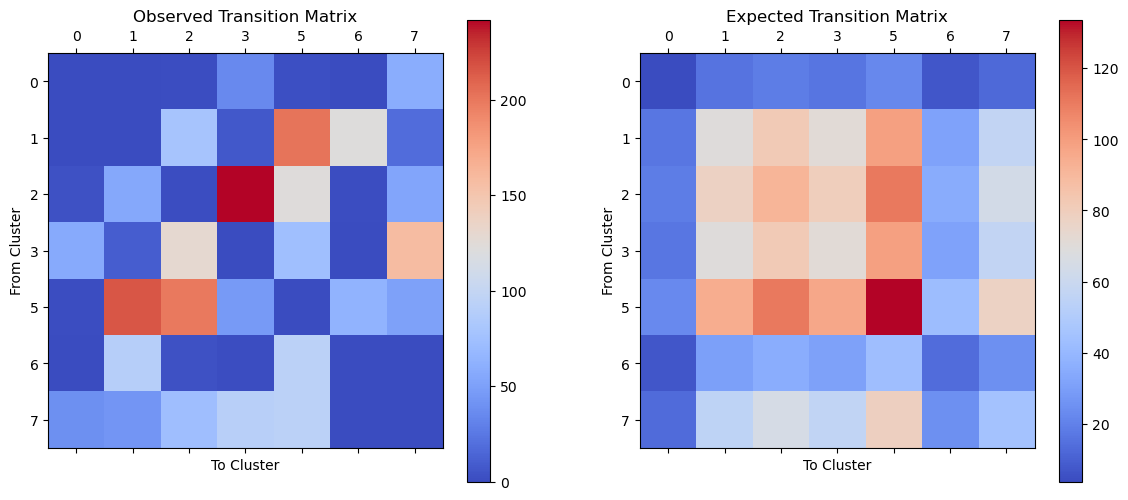

In [157]:
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Manually set the order of clusters
clusters_list = ['0', '1', '2', '3', '5', '6', '7']  # Ensure this list is ordered as desired

# Calculate total counts for expected probabilities
total_counts = sum(cluster_counts[cluster] for cluster in clusters_list)

# Calculate expected probabilities for each cluster
expected_probabilities = {cluster: cluster_counts[cluster] / total_counts for cluster in clusters_list}

# Initialize observed and expected matrices
observed = np.zeros((len(clusters_list), len(clusters_list)))
expected = np.zeros((len(clusters_list), len(clusters_list)))

# Fill observed and expected matrices
for i, cluster_i in enumerate(clusters_list):
    for j, cluster_j in enumerate(clusters_list):
        observed[i, j] = transition_counts[cluster_i].get(cluster_j, 0)
        expected[i, j] = expected_probabilities[cluster_j] * sum(transition_counts[cluster_i].values())

# Perform the chi-squared test
chi2, p_value, _, _ = chi2_contingency(observed, correction=False)

# Print results
print(f"Chi-squared Test Results: Chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("The transition probabilities are statistically significant.")
else:
    print("No significant difference in transition probabilities.")

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Observed transition matrix
cax1 = ax1.matshow(observed, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('Observed Transition Matrix')
ax1.set_xticks(range(len(clusters_list)))
ax1.set_yticks(range(len(clusters_list)))
ax1.set_xticklabels(clusters_list)
ax1.set_yticklabels(clusters_list)
ax1.set_xlabel('To Cluster')
ax1.set_ylabel('From Cluster')

# Expected transition matrix
cax2 = ax2.matshow(expected, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('Expected Transition Matrix')
ax2.set_xticks(range(len(clusters_list)))
ax2.set_yticks(range(len(clusters_list)))
ax2.set_xticklabels(clusters_list)
ax2.set_yticklabels(clusters_list)
ax2.set_xlabel('To Cluster')
ax2.set_ylabel('From Cluster')

plt.show()

In [158]:
# Fill observed and expected matrices, adjusting the expected matrix for no self-transitions
for i, cluster_i in enumerate(clusters_list):
    total_transitions_to_others = sum(transition_counts[cluster_i].values()) - transition_counts[cluster_i].get(cluster_i, 0)
    for j, cluster_j in enumerate(clusters_list):
        observed[i, j] = transition_counts[cluster_i].get(cluster_j, 0)
        if cluster_i == cluster_j:
            expected[i, j] = 0  # No self-transitions expected
        else:
            expected[i, j] = expected_probabilities[cluster_j] * total_transitions_to_others

# Proceed with chi-squared test, plotting, etc.
chi2, p_value, _, _ = chi2_contingency(observed, correction=False, lambda_="log-likelihood")

# Print results
print(f"Chi-squared Test Results: Chi2 = {chi2}, p-value = {p_value}")
if p_value < 0.05:
    print("The transition probabilities are statistically significant.")
else:
    print("No significant difference in transition probabilities.")

Chi-squared Test Results: Chi2 = 2760.776856159747, p-value = 0.0
The transition probabilities are statistically significant.


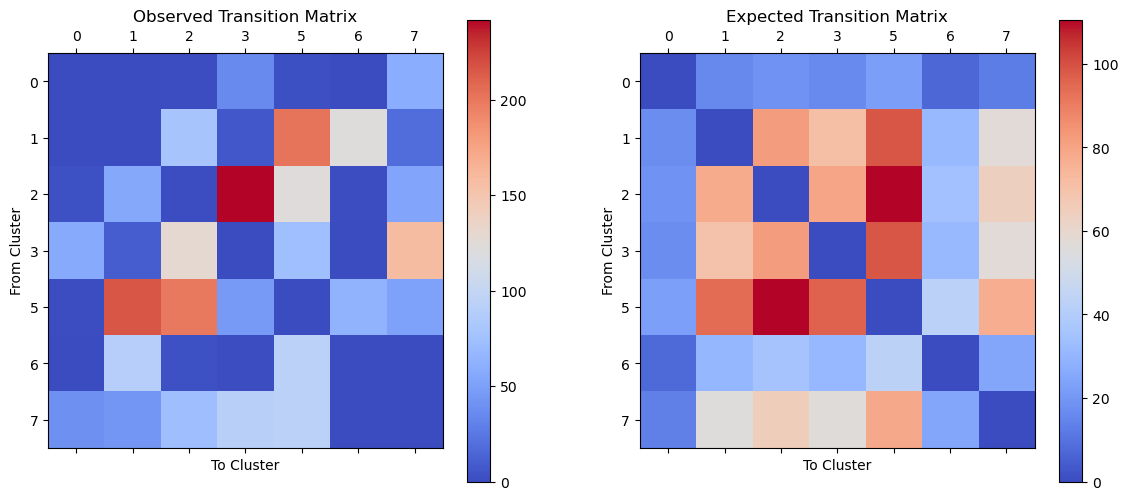

In [159]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Observed transition matrix
cax1 = ax1.matshow(observed, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax1, ax=ax1)
ax1.set_title('Observed Transition Matrix')
ax1.set_xticks(range(len(clusters_list)))
ax1.set_yticks(range(len(clusters_list)))
ax1.set_xticklabels(clusters_list)
ax1.set_yticklabels(clusters_list)
ax1.set_xlabel('To Cluster')
ax1.set_ylabel('From Cluster')

# Expected transition matrix
cax2 = ax2.matshow(expected, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax2, ax=ax2)
ax2.set_title('Expected Transition Matrix')
ax2.set_xticks(range(len(clusters_list)))
ax2.set_yticks(range(len(clusters_list)))
ax2.set_xticklabels(clusters_list)
ax2.set_yticklabels(clusters_list)
ax2.set_xlabel('To Cluster')
ax2.set_ylabel('From Cluster')

plt.show()

In [160]:
data = np.random.rand(10, 10)
data

array([[0.78513239, 0.42545802, 0.15063973, 0.22036178, 0.80643023,
        0.97645471, 0.17006412, 0.71205767, 0.20207285, 0.7209873 ],
       [0.22709343, 0.1617093 , 0.86425109, 0.18696519, 0.05890263,
        0.97855327, 0.75399958, 0.49185856, 0.35588802, 0.7571418 ],
       [0.71959633, 0.49851931, 0.24666343, 0.60508722, 0.04589432,
        0.71181474, 0.71368705, 0.53835888, 0.47455472, 0.55719814],
       [0.43530625, 0.78127393, 0.66817515, 0.88910773, 0.28874276,
        0.93394879, 0.33884494, 0.19148157, 0.88430839, 0.6744053 ],
       [0.50014418, 0.41271126, 0.84820811, 0.31815606, 0.23023322,
        0.16093787, 0.95825699, 0.05359743, 0.07404951, 0.83312288],
       [0.38002832, 0.75279829, 0.29954119, 0.10377932, 0.63084712,
        0.4786491 , 0.19047837, 0.04477635, 0.83415208, 0.10740232],
       [0.29533162, 0.72667872, 0.45494444, 0.39066502, 0.0202434 ,
        0.28799624, 0.689757  , 0.39977693, 0.12569605, 0.61240681],
       [0.74561341, 0.371047  , 0.3973907